In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, LSTM, Bidirectional, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to compute Bollinger Bands and ATR
def add_technical_indicators(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['Upper_Band'] = df['SMA_20'] + (df['Close'].rolling(window=20).std() * 2)
    df['Lower_Band'] = df['SMA_20'] - (df['Close'].rolling(window=20).std() * 2)
    df['ATR'] = df['High'] - df['Low']
    df = df.dropna()
    return df

# Data Preparation
def prepare_data(df, sequence_length=60):
    df = add_technical_indicators(df)  # Add technical indicators
    features = ['Close', 'Upper_Band', 'Lower_Band', 'ATR']
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[features])

    X, y = [], []
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled[i:i+sequence_length])
        y.append(df_scaled[i+sequence_length, 0])  # Predicting Close price

    return np.array(X), np.array(y), scaler

# Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    ffn = keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1])
    ])

    x_ffn = ffn(x)
    x_ffn = Dropout(dropout)(x_ffn)
    x = Add()([x_ffn, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Hybrid Transformer-LSTM Model
def build_hybrid_model(input_shape, head_size=128, num_heads=8, ff_dim=128, num_blocks=3, dropout=0.3):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)

    lstm_out = Bidirectional(LSTM(128, return_sequences=False))(inputs)

    x = Concatenate()([x, lstm_out])
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                  loss=tf.keras.losses.Huber(),
                  metrics=['mae'])
    return model

# Function to plot actual vs predicted prices
def plot_results(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(y_true)), y_true, label="Actual", color='blue')
    plt.plot(range(len(y_pred)), y_pred, label="Predicted", color='red')
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.title(title)
    plt.legend()
    plt.show()

# Load dataset
data_path = os.path.join("..", "data", "Nifty50_Train_max.csv")
df = pd.read_csv(data_path)  # Ensure the CSV contains 'Close', 'High', 'Low'
X, y, scaler = prepare_data(df, sequence_length=60)
train_size = int(0.8 * len(X))  # Sequential Split
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build & Train Model
model = build_hybrid_model(input_shape=(60, 4))  # 4 features (Close, Upper_Band, Lower_Band, ATR)
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))








Epoch 1/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - loss: 0.0030 - mae: 0.0546 - val_loss: 0.0105 - val_mae: 0.1434
Epoch 2/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - loss: 4.6418e-04 - mae: 0.0226 - val_loss: 0.0132 - val_mae: 0.1614
Epoch 3/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 4.1411e-04 - mae: 0.0211 - val_loss: 0.0020 - val_mae: 0.0602
Epoch 4/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 3.2438e-04 - mae: 0.0182 - val_loss: 0.0014 - val_mae: 0.0501
Epoch 5/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 3.4864e-04 - mae: 0.0189 - val_loss: 0.0014 - val_mae: 0.0508
Epoch 6/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 3.1545e-04 - mae: 0.0182 - val_loss: 3.5200e-04 - val_mae: 0.0228
Epoch 7/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 2.5910e-04 - mae: 0.0161 - val_loss: 1.2949e-04 - val_mae: 0.0127
Epoch 8/100
208/208 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 2.5485e-04 - mae: 0.0155 - val_loss: 2.7175e-04 - val_mae: 0.019

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, LSTM, Bidirectional, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to compute Bollinger Bands and ATR
def add_technical_indicators(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['Upper_Band'] = df['SMA_20'] + (df['Close'].rolling(window=20).std() * 2)
    df['Lower_Band'] = df['SMA_20'] - (df['Close'].rolling(window=20).std() * 2)
    df['ATR'] = df['High'] - df['Low']
    df = df.dropna()
    return df

# Data Preparation
def prepare_data(df, sequence_length=60):
    df = add_technical_indicators(df)  # Add technical indicators
    features = ['Close', 'Upper_Band', 'Lower_Band', 'ATR']
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df[features])

    X, y = [], []
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled[i:i+sequence_length])
        y.append(df_scaled[i+sequence_length, 0])  # Predicting Close price

    return np.array(X), np.array(y), scaler

# Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)

    ffn = keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1])
    ])

    x_ffn = ffn(x)
    x_ffn = Dropout(dropout)(x_ffn)
    x = Add()([x_ffn, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# Hybrid Transformer-LSTM Model
def build_hybrid_model(input_shape, head_size=128, num_heads=8, ff_dim=128, num_blocks=3, dropout=0.3):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)

    lstm_out = Bidirectional(LSTM(128, return_sequences=False))(inputs)

    x = Concatenate()([x, lstm_out])
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                  loss=tf.keras.losses.Huber(),
                  metrics=['mae'])
    return model

# Function to plot actual vs predicted prices
def plot_results(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(y_true)), y_true, label="Actual", color='blue')
    plt.plot(range(len(y_pred)), y_pred, label="Predicted", color='red')
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.title(title)
    plt.legend()
    plt.show()

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Final_Project(Stock prediction)/Datasets/Nifty50_Train_max.csv")  # Ensure the CSV contains 'Close', 'High', 'Low'
X, y, scaler = prepare_data(df, sequence_length=60)
train_size = int(0.8 * len(X))  # Sequential Split
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Build & Train Model
model = build_hybrid_model(input_shape=(60, 4))  # 4 features (Close, Upper_Band, Lower_Band, ATR)
model.summary()



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 60, 4)          │         19,460 │ input_layer_4[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 60, 4)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 60, 4)          │              0 │ dropout_11[0][0],      │
│                           │                        │                │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 60, 4)          │              8 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 60, 4)          │          1,156 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 60, 4)          │              0 │ sequential_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 60, 4)          │              0 │ dropout_12[0][0],      │
│                           │                        │                │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_7     │ (None, 60, 4)          │              8 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 60, 4)          │         19,460 │ layer_normalization_7… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 60, 4)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 60, 4)          │              0 │ dropout_14[0][0],      │
│                           │                        │                │ layer_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_8     │ (None, 60, 4)          │              8 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 60, 4)          │          1,156 │ layer_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 60, 4)          │              0 │ sequential_4[0][0]     │
├──────────────────────

 Total params: 231,625 (904.79 KB)

 Trainable params: 231,625 (904.79 KB)

 Non-trainable params: 0 (0.00 B)

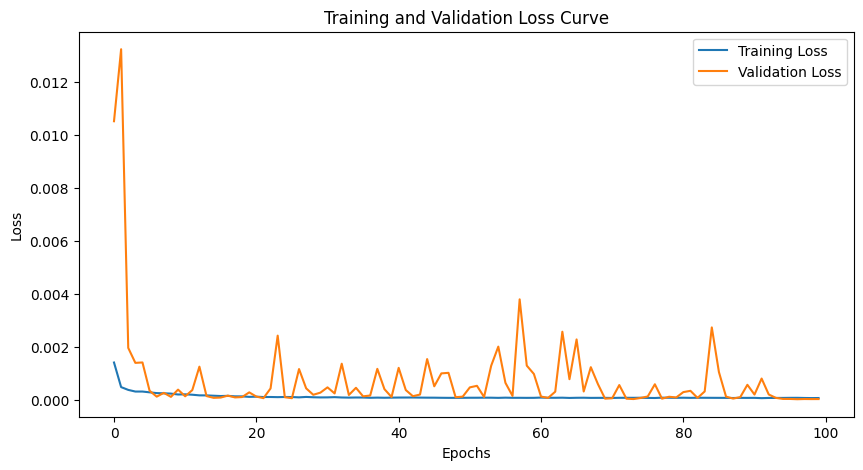

In [ ]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MAE: 159.4657534330873, RMSE: 206.75010014753258, MAPE: 0.836283405425379%


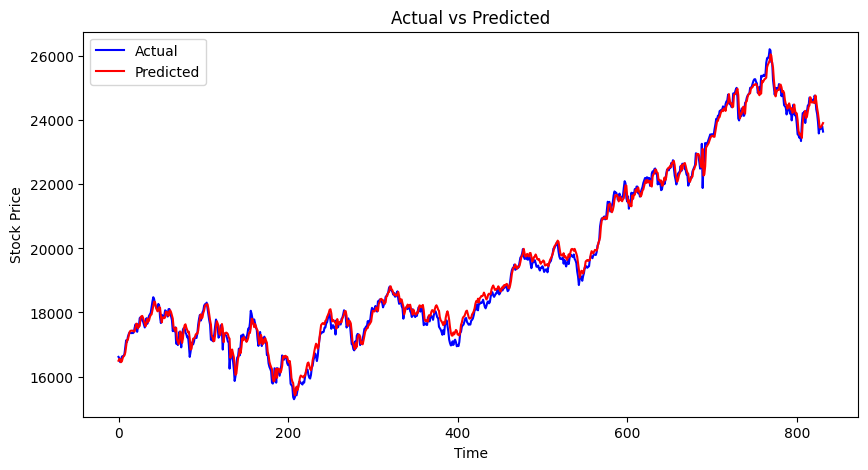

In [ ]:


# Predict and Evaluate
y_pred = model.predict(X_test)
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), 3))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 3))), axis=1))[:, 0]

mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100

print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")
plot_results(y_test_actual, y_pred_actual)